In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

In [2]:
# Set paths to train and validation folders
train_path = "C:\\Users\\poloj\\Downloads\\minorproject\\tomato\\train"
valid_path = "C:\\Users\\poloj\\Downloads\\minorproject\\tomato\\val"

In [6]:
# Define image data generators with data augmentation
image_size = (224, 224)
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [11]:
valid_datagen = ImageDataGenerator(rescale=1.0/255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

Found 10000 images belonging to 10 classes.


In [12]:
valid_generator = valid_datagen.flow_from_directory(
    directory=valid_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

Found 1000 images belonging to 10 classes.


In [9]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_random_images(directory, num_images=9, num_columns=3):
    subfolders = [subfolder for subfolder in os.listdir(directory) if os.path.isdir(os.path.join(directory, subfolder))]
    if len(subfolders) == 0:
        print(f"No subfolders found in {directory}")
        return
    
    random_subfolder = random.choice(subfolders)
    subfolder_path = os.path.join(directory, random_subfolder)
    image_files = [filename for filename in os.listdir(subfolder_path) if filename.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if len(image_files) < num_images:
        print(f"Number of available images in {subfolder_path} is less than {num_images}")
        return
    
    random_files = random.sample(image_files, num_images)
    num_rows = (num_images + num_columns - 1) // num_columns
    plt.figure(figsize=(15, 10))
    
    for i, filename in enumerate(random_files):
        img_path = os.path.join(subfolder_path, filename)
        img = mpimg.imread(img_path)
        plt.subplot(num_rows, num_columns, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(filename)
    
    plt.tight_layout()
    plt.show()

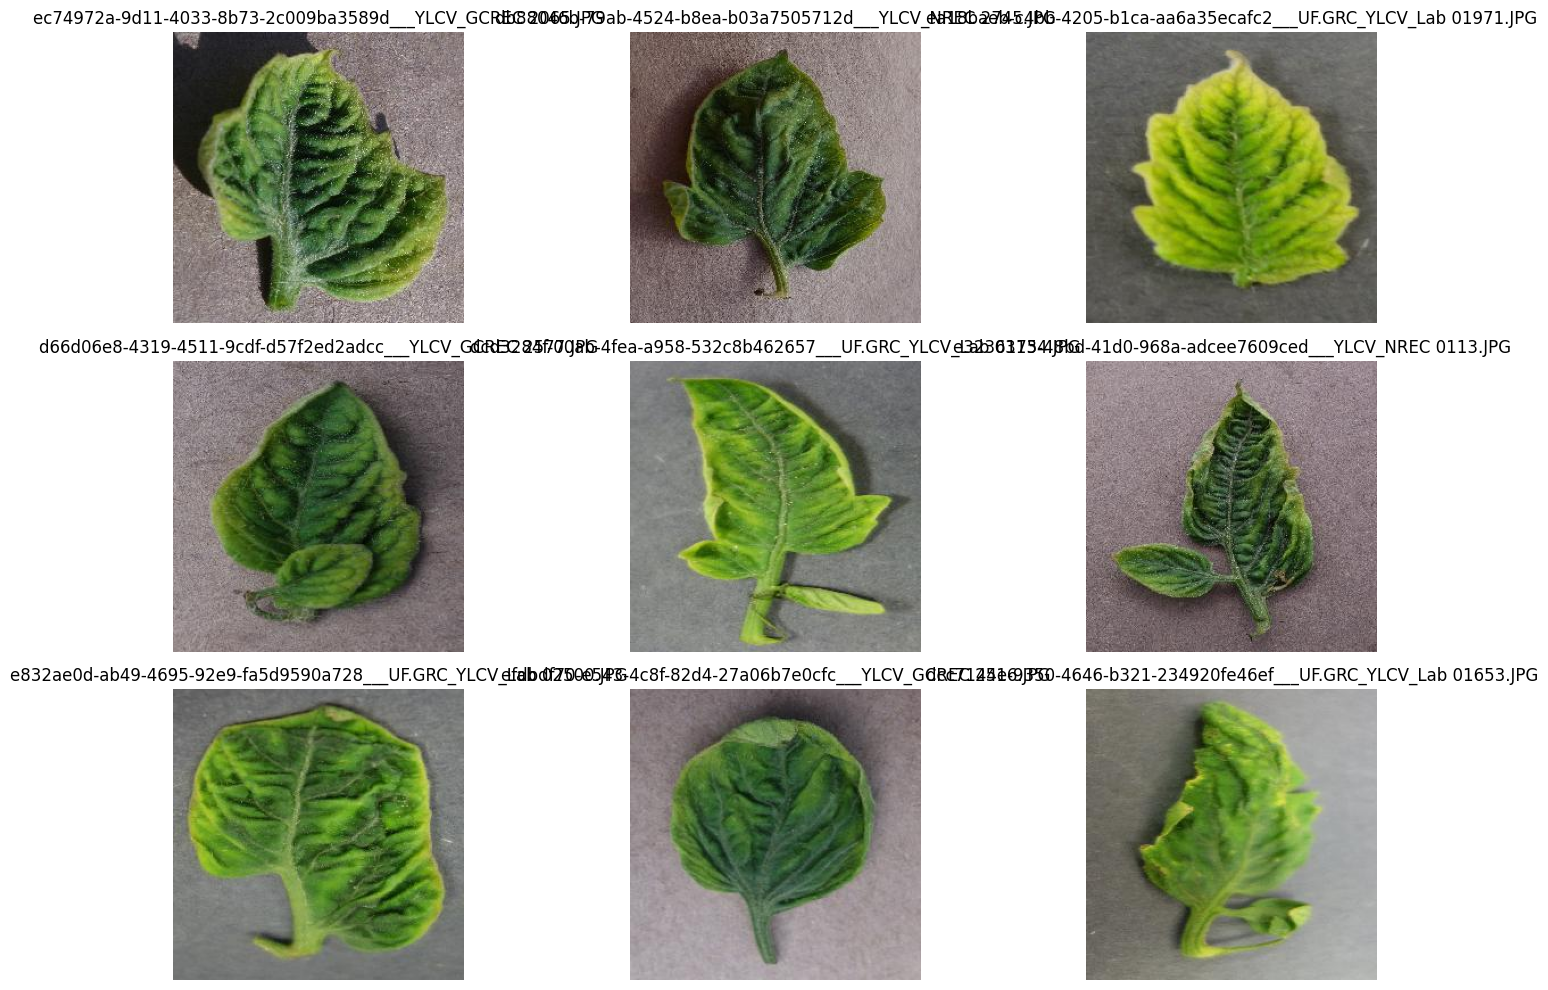

In [13]:
# Call the function with the desired directory and number of images
display_random_images(train_path, num_images=9, num_columns=3)


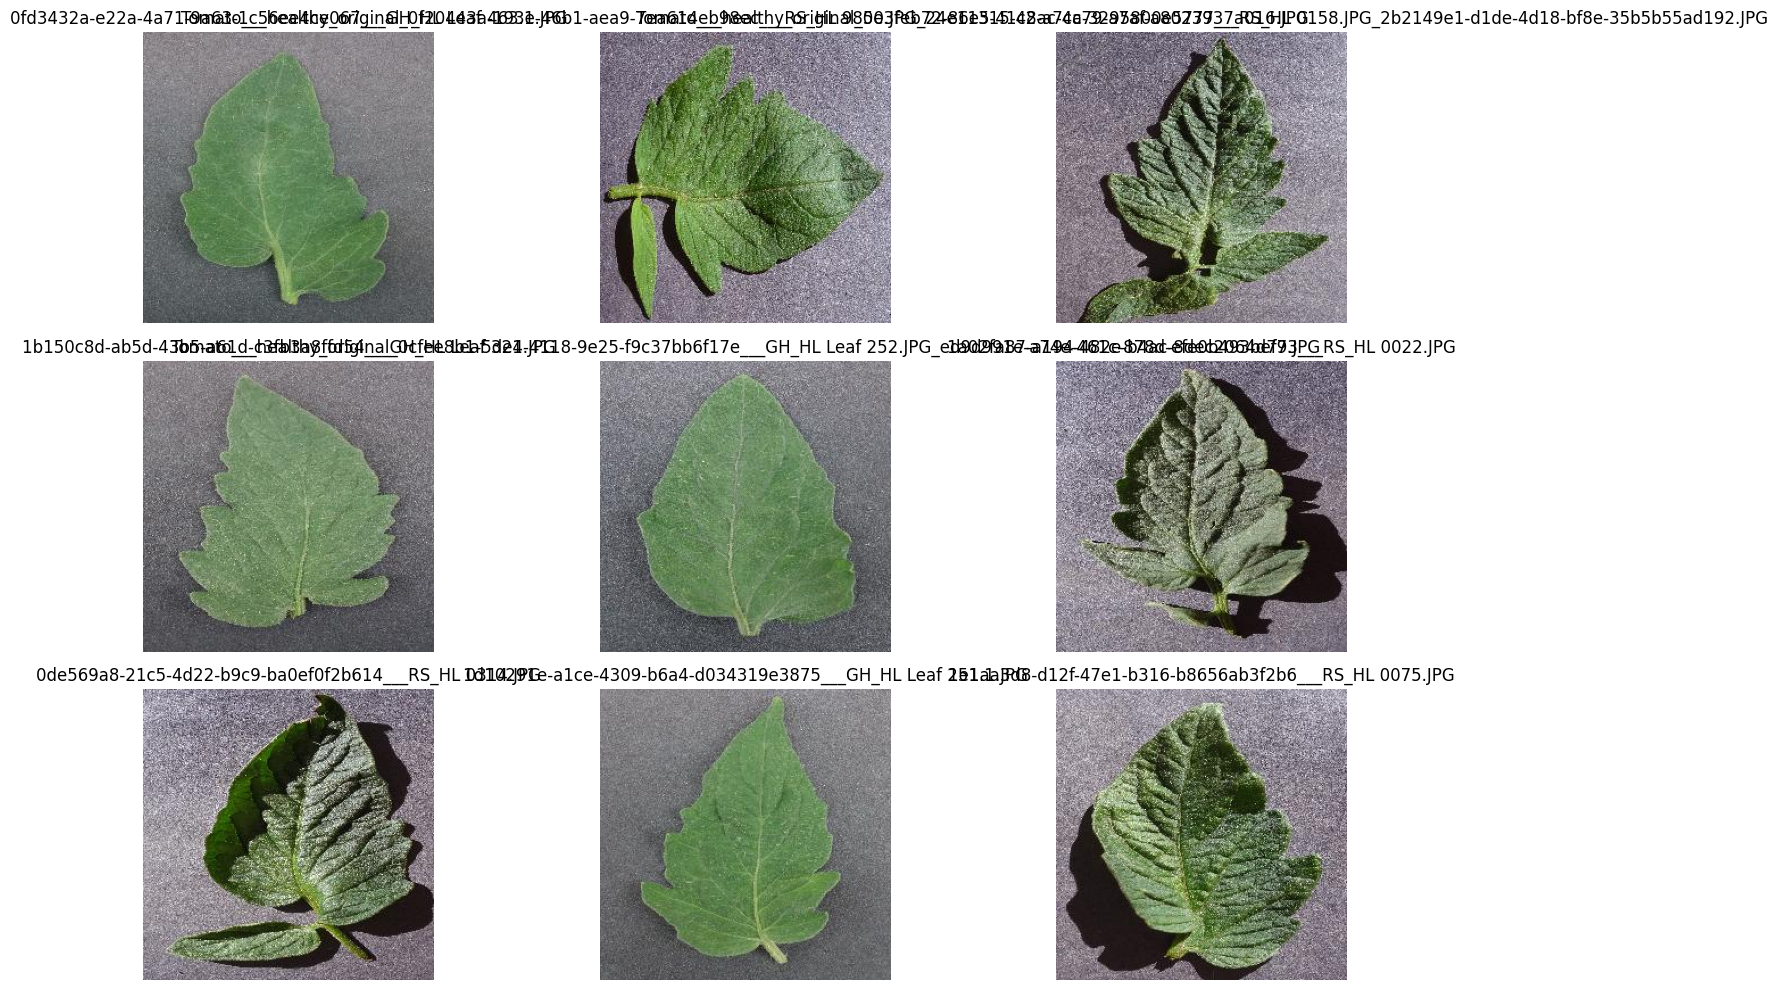

In [14]:
# Call the function with the desired directory and number of images
display_random_images(valid_path, num_images=9, num_columns=3)

In [15]:
# Create a CNN model
num_classes = len(train_generator.class_indices)
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

In [16]:
from tensorflow.keras.optimizers import Adam

# Compile the model with Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # You can adjust the learning rate as needed
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [17]:
import scipy

from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=[early_stopping]  # Add the EarlyStopping callback
)

Epoch 1/5


313/313 [==============================] - 354s 1s/step - loss: 1.9854 - accuracy: 0.2853 - val_loss: 1.4731 - val_accuracy: 0.4570
Epoch 2/5
313/313 [==============================] - 360s 1s/step - loss: 1.4817 - accuracy: 0.4938 - val_loss: 1.1584 - val_accuracy: 0.6210
Epoch 3/5
313/313 [==============================] - 345s 1s/step - loss: 1.2824 - accuracy: 0.5643 - val_loss: 1.2867 - val_accuracy: 0.5630
Epoch 4/5
313/313 [==============================] - 342s 1s/step - loss: 1.1881 - accuracy: 0.5882 - val_loss: 1.0541 - val_accuracy: 0.6300
Epoch 5/5
313/313 [==============================] - 321s 1s/step - loss: 1.0967 - accuracy: 0.6235 - val_loss: 0.9118 - val_accuracy: 0.6980


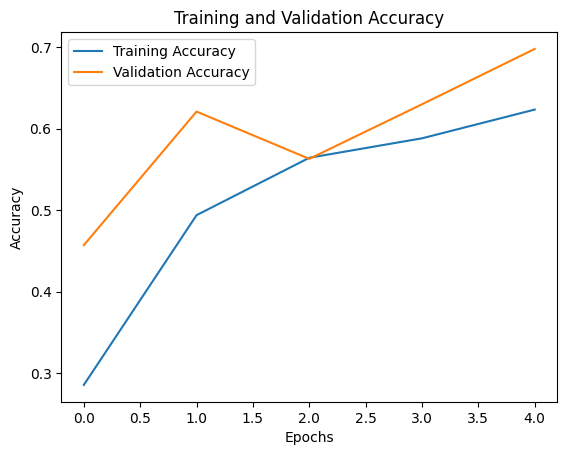

In [18]:
# Plot training and validation accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

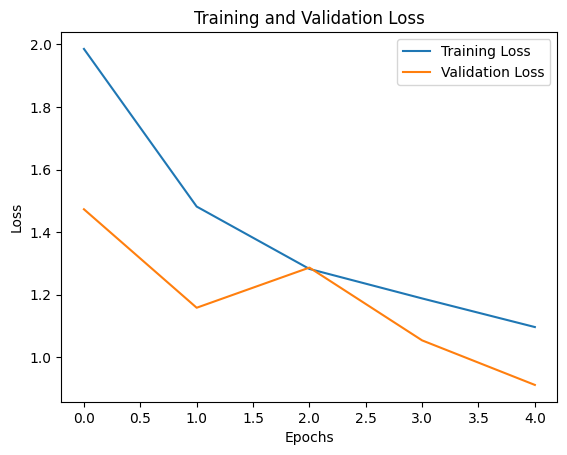

In [19]:
# Plot training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [20]:
# Make predictions on test data
test_loss, test_accuracy = model.evaluate(valid_generator, steps=len(valid_generator))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the trained model
model.save("trained_model.h5")
print("Trained model saved as 'trained_model.h5'")

32/32 [==============================] - 6s 185ms/step - loss: 0.9118 - accuracy: 0.6980
Test Loss: 0.9118
Test Accuracy: 0.6980
Trained model saved as 'trained_model.h5'


1/1 [==============================] - 0s 343ms/step


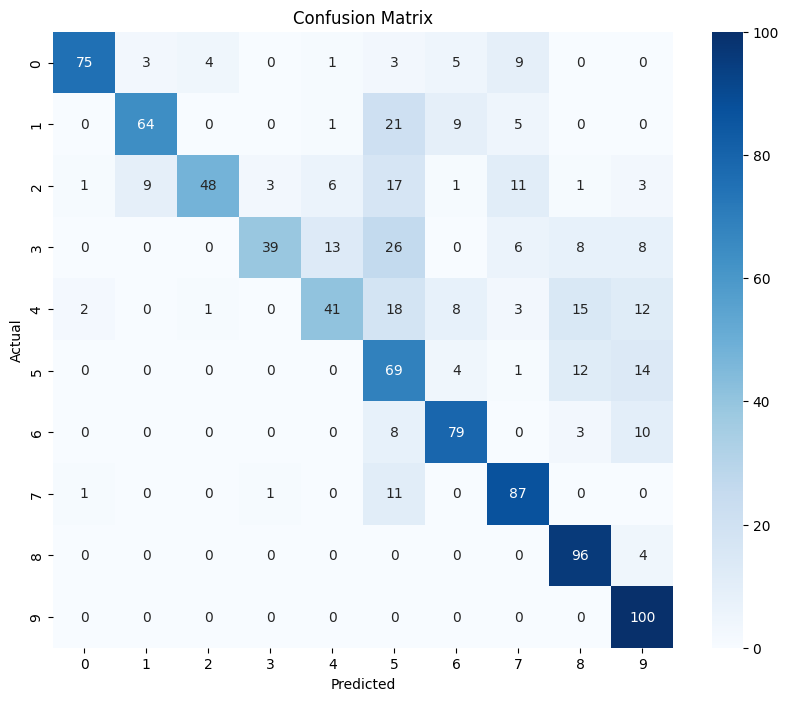

In [21]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
# Load the saved model
loaded_model = tf.keras.models.load_model("trained_model.h5")

# Initialize variables
num_samples = len(valid_generator.filenames)
batch_size = 32
num_batches = int(np.ceil(num_samples / batch_size))
all_test_labels = []
all_predicted_labels = []

# Generate predictions in batches
for _ in range(num_batches):
    batch_images, batch_labels = next(valid_generator)
    batch_predictions = loaded_model.predict(batch_images)
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)
    
    all_test_labels.extend(np.argmax(batch_labels, axis=1))
    all_predicted_labels.extend(batch_predicted_labels)

# Generate confusion matrix
cm = confusion_matrix(all_test_labels, all_predicted_labels)

# Plot the confusion matrix
class_names = [str(i) for i in range(num_classes)]  # Replace with actual class names if available
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()